In [1]:
%cd /home/a_razumov/projects/k-space-mri
%env CUDA_VISIBLE_DEVICES=3
import os
import sys
from k_space_reconstruction.nets.unet import UnetSMPModule, Unet
from k_space_reconstruction.nets.enet import ENet
from k_space_reconstruction.nets.mwcnn import MWCNN
from k_space_reconstruction.utils.kspace import EquispacedMaskFunc, RandomMaskFunc
from k_space_reconstruction.utils.kspace import pt_spatial2kspace as Ft
from k_space_reconstruction.utils.kspace import pt_kspace2spatial as IFt
import datetime
import torch
import torchvision
import numpy as np
import pylab as plt
plt.style.use('dark_background')
import albumentations
from tqdm.notebook import tqdm
import numpy as np
import h5py
import pylab as plt
import torch
import torch.nn.functional as F

import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import nibabel

import torchio as tio
from torchio import AFFINE, DATA
from pathlib import Path

import torch
import torch.nn as nn
import torch.utils.data
import torchvision.transforms as transforms

from os.path import isdir, join
from typing import Callable, Dict, List, Any

/home/a_razumov/projects/k-space-mri
env: CUDA_VISIBLE_DEVICES=3


In [2]:
class DoubleConv(nn.Module):
    """(Conv3D -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True),

            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True)
          )

    def forward(self,x):
        return self.double_conv(x)

    
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2, 2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.encoder(x)

    
class Up(nn.Module):

    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        
        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose3d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

    
class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        return self.conv(x)


class UNet3d(nn.Module):
    def __init__(self, in_channels, n_classes, n_channels):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        self.conv = DoubleConv(in_channels, n_channels)
        self.enc1 = Down(n_channels, 2 * n_channels)
        self.enc2 = Down(2 * n_channels, 4 * n_channels)
        self.enc3 = Down(4 * n_channels, 8 * n_channels)
        self.enc4 = Down(8 * n_channels, 8 * n_channels)

        self.dec1 = Up(16 * n_channels, 4 * n_channels)
        self.dec2 = Up(8 * n_channels, 2 * n_channels)
        self.dec3 = Up(4 * n_channels, n_channels)
        self.dec4 = Up(2 * n_channels, n_channels)
        self.out = Out(n_channels, n_classes)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)

        mask = self.dec1(x5, x4)
        mask = self.dec2(mask, x3)
        mask = self.dec3(mask, x2)
        mask = self.dec4(mask, x1)
        mask = self.out(mask)

        return mask

In [3]:
def dice_coeff_3d_classes(true, logits, eps=1e-11):
    num_classes = logits.shape[0]
    probas = torch.nn.functional.softmax(logits, dim=0)
    probas[probas > 0.5] = 1
    probas[probas <= 0.5] = 0
    pmask = torch.zeros_like(true).float()
    for i in range(1, num_classes): pmask[0] += probas[i] * i
    dice_ls = []
    # WT
    true_1_hot = ((true==1) | (true==2) | (true==3)).float().flatten()
    pred_1_hot = ((pmask==1) | (pmask==2) | (pmask==3)).float().flatten()
    intersection = torch.sum(pred_1_hot * true_1_hot)
    cardinality = torch.sum(pred_1_hot + true_1_hot)
    dice_ls.append((2. * intersection / (cardinality + eps)).item())
    # ET
    true_1_hot = ((true==1) | (true==3)).float().flatten()
    pred_1_hot = ((pmask==1) | (pmask==3)).float().flatten()
    intersection = torch.sum(pred_1_hot * true_1_hot)
    cardinality = torch.sum(pred_1_hot + true_1_hot)
    dice_ls.append((2. * intersection / (cardinality + eps)).item())
    # TC
    true_1_hot = ((true==1)).float().flatten()
    pred_1_hot = ((pmask==1)).float().flatten()
    intersection = torch.sum(pred_1_hot * true_1_hot)
    cardinality = torch.sum(pred_1_hot + true_1_hot)
    dice_ls.append((2. * intersection / (cardinality + eps)).item())
    return dice_ls


class BraTS3dDataset(torch.utils.data.Dataset):

    def __init__(self, hf_path: str, aug=None, indexes=None):
        super().__init__()
        self.hf = h5py.File(hf_path)
        self.aug = aug
        if indexes is not None:
            self.indexes = [str(i) for i in indexes]
        else:
            self.indexes = [k for k in self.hf.keys()]

    def __len__(self) -> int:
        return len(self.indexes)
    
    def __getitem__(self, item: int):
        key = self.indexes[item]
        img = self.hf[key][:-1,:,:,:]
        mask = self.hf[key][-1:,:,:,:]
        mask[mask==4] = 3
        if self.aug:
            aug = self.aug(image=img, mask=mask)
            img = aug['image']
            mask = aug['mask']
        img = torch.tensor(img).float()
        mask = torch.tensor(mask).long()
        img = img.movedim(3,1)
        mask = mask.movedim(3,1)
        mean = img.mean(dim=(2,3)).unsqueeze(2).unsqueeze(2)
        std = img.std(dim=(2,3)).unsqueeze(2).unsqueeze(2)
        img = (img - mean) / (std + 1e-11)
        return mask, img, mean, std


def test_3d_on_classes_sampling_pattern(sampling, model, val_3d_dataset):
    dice_scores = []
    with torch.no_grad():
        for i in tqdm(range(len(val_3d_dataset))):
            mask, img, mean, std = val_3d_dataset[i]
            img = (IFt(Ft(img * std + mean) * sampling).abs() - mean) / (std + 1e-11)
            logits = model(img.cuda().float().unsqueeze(0))[0].cpu()
            dice_scores.append(dice_coeff_3d_classes(mask, logits))
    return dice_scores

In [ ]:
import pytorch_lightning as pl
from collections import OrderedDict

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = UNet3d(in_channels=4, n_classes=4, n_channels=24).to(device).train(False).eval()
state_dict = pl.utilities.cloud_io.load(
    'notebooks/dls/new_logs/lightning_logs/version_0/checkpoints/epoch=155-val_loss=0.17864.ckpt', map_location='cpu')['state_dict']
model.load_state_dict(OrderedDict({k[4:]: v for k, v in state_dict.items()}))
for p in model.parameters(): p.requires_grad = False
    
train_3d_dataset = BraTS3dDataset('/home/a_razumov/small_datasets/brats_h5/train.h5')
val_3d_dataset = BraTS3dDataset('/home/a_razumov/small_datasets/brats_h5/val.h5')

In [5]:
mask, img, mean, std = val_3d_dataset[1]
with torch.no_grad():
    logits = model(img.cuda().float().unsqueeze(0))[0].cpu()
print(dice_coeff_3d_classes(mask, logits))
probas = torch.nn.functional.softmax(logits, dim=0)
probas[probas > 0.5] = 1
probas[probas <= 0.5] = 0
pmask = torch.zeros_like(mask).float()
for i in range(1, 4): pmask[0] += probas[i] * i

[0.9497544765472412, 0.5838958024978638, 0.5587893724441528]


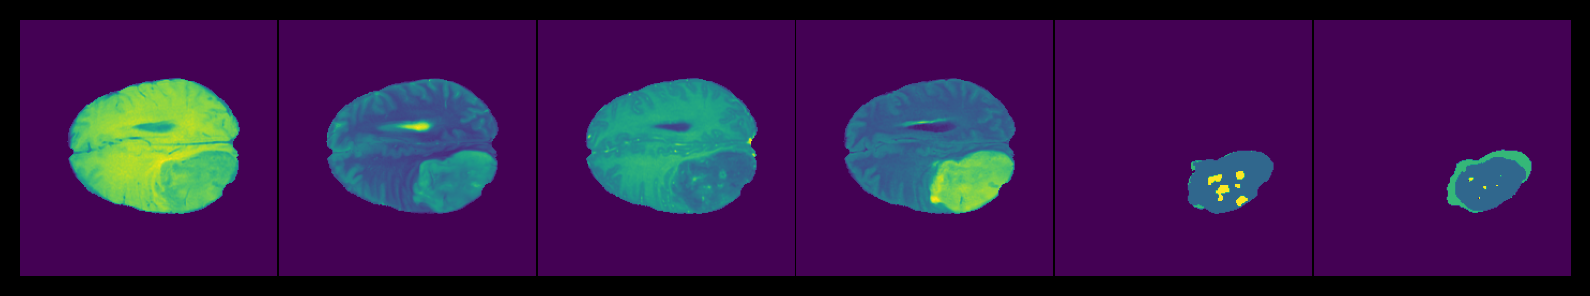

In [6]:
z = 100
fig, ax = plt.subplots(figsize=(10,10), ncols=6, dpi=200,
                       subplot_kw=dict(frameon=False, xticks=[], yticks=[]),
                       gridspec_kw=dict(wspace=0.01, hspace=0.0))
ax[0].imshow(img[0,z])
ax[1].imshow(img[1,z])
ax[2].imshow(img[2,z])
ax[3].imshow(img[3,z])
ax[4].imshow(mask[0,z])
im = ax[5].imshow(pmask[0,z])
# fig.colorbar(im)
plt.show()

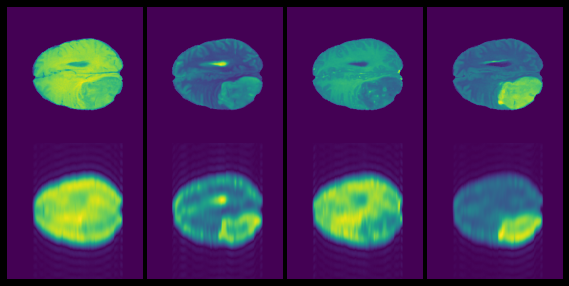

In [7]:
fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [15])((240, 240))[0]).cpu().float().unsqueeze(0).unsqueeze(0).unsqueeze(0)
zm = torch.zeros(240).cpu().float()
zm[240//2 - int(16)//2 : 240//2 + int(16)//2] = 1
zm = zm.unsqueeze(1).unsqueeze(0).unsqueeze(0)
fm = torch.ones(240).cpu().float()

rimg = (IFt(Ft(img * std + mean) * zm).abs() - mean) / (std + 1e-11)

fig,ax = plt.subplots(ncols=4,nrows=2, figsize=(10,5),
                      subplot_kw=dict(frameon=False, xticks=[], yticks=[]),
                      gridspec_kw=dict(wspace=0.01, hspace=0.0))
ax[0,0].imshow(img[0,z])
ax[0,1].imshow(img[1,z])
ax[0,2].imshow(img[2,z])
ax[0,3].imshow(img[3,z])
ax[1,0].imshow(rimg[0,z])
ax[1,1].imshow(rimg[1,z])
ax[1,2].imshow(rimg[2,z])
ax[1,3].imshow(rimg[3,z])
plt.show()

In [8]:
fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [15])((240, 240))[0]).cpu().float().unsqueeze(1).unsqueeze(0).unsqueeze(0)
zm = torch.zeros(240).cpu().float()
zm[240//2 - int(16)//2 : 240//2 + int(16)//2] = 1
zm = zm.unsqueeze(1).unsqueeze(0).unsqueeze(0)
fm = torch.ones(240).cpu().float()

dice_scores = dict(
    fastmri=test_3d_on_classes_sampling_pattern(fastmri_mask_x16, model, val_3d_dataset), 
    center=test_3d_on_classes_sampling_pattern(zm, model, val_3d_dataset),
    full=test_3d_on_classes_sampling_pattern(fm, model, val_3d_dataset)
)

In [9]:
class_map = {0: 'WT', 1: 'ET', 2: 'TC'}
for name in dice_scores.keys():
    arr = np.array(dice_scores[name]).T
    print('##############', name, '##############')
    print(pd.DataFrame.from_dict({class_map[i]:arr[i] for i in range(arr.shape[0])}).describe())

############## fastmri ##############
               WT          ET          TC
count  111.000000  111.000000  111.000000
mean     0.654955    0.526508    0.276624
std      0.206837    0.268763    0.267045
min      0.093239    0.000000    0.000000
25%      0.548647    0.316297    0.021568
50%      0.715674    0.607559    0.201941
75%      0.822784    0.745348    0.504429
max      0.910201    0.866505    0.846459
############## center ##############
               WT          ET          TC
count  111.000000  111.000000  111.000000
mean     0.681968    0.581517    0.342607
std      0.226616    0.276492    0.290076
min      0.075929    0.000000    0.000000
25%      0.557655    0.370479    0.033265
50%      0.761234    0.668006    0.278838
75%      0.865217    0.810102    0.608360
max      0.926169    0.890095    0.868563
############## full ##############
               WT          ET          TC
count  111.000000  111.000000  111.000000
mean     0.888435    0.792346    0.622844
std     